### VGGNet 구현

3x3 conv x2 (channel 64)  
3x3 conv x2 (channel 128)  
3x3 conv x3 (channel 256)  
3x3 conv x3 (channel 512)  
3x3 conv x3 (channel 512)  
FC layer x3  

    FC layer 4096  
        FC layer 4096  
        FC layer 1000  

In [1]:
#!pip install tqdm
!pip install torchsummary

In [2]:
import torch
import torch.nn as nn 
import torch.optim as optim
import torch.nn.init as init
from torchsummary import summary

In [3]:
# conv2
def conv_2_block(in_dim, out_dim):
    model=nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

In [4]:
#conv3
def conv_3_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

In [5]:
#VGG16
class VGG(nn.Module):
    def __init__(self,base_dim,num_classes=10):
        super(VGG,self).__init__()
        self.feature = nn.Sequential(
            conv_2_block(3,base_dim),
            conv_2_block(base_dim,2*base_dim),
            conv_3_block(2*base_dim,4*base_dim),
            conv_3_block(4*base_dim,8*base_dim),
            conv_3_block(8*base_dim,8*base_dim)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(8*base_dim*1*1,4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1000),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1000, num_classes),
        )

    def forward(self, x):
        x = self.feature(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.fc_layer(x)
        return x

# model summary

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = VGG(base_dim=64).to(device)

summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

In [6]:
#Dataset
import torchvision
import torchvision.datasets as datasets # 이미지 데이터셋 집합체
import torchvision.transforms as transforms # 이미지 변환 툴
from torch.utils.data import DataLoader # 학습 및 배치로 모델에 넣어주기 위한 툴

# Transform 정의
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


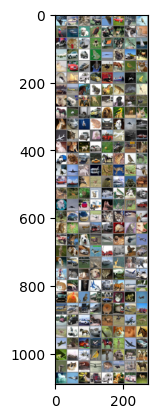

deer  ship  deer  deer  bird  car   deer  bird  bird  ship  dog   bird  truck deer  deer  cat   car   cat   truck dog   truck dog   bird  ship  plane car   car   frog  plane frog  truck deer  dog   car   car   bird  bird  horse bird  cat   dog   ship  car   car   dog   ship  plane frog  car   plane horse frog  horse frog  horse plane dog   dog   horse deer  plane dog   ship  deer  horse bird  cat   truck dog   bird  deer  deer  deer  car   ship  frog  truck dog   plane ship  plane cat   truck dog   truck plane plane car   dog   cat   deer  car   deer  horse horse cat   truck dog   truck car   horse frog  bird  horse cat   plane dog   plane bird  dog   frog  deer  car   ship  bird  deer  bird  ship  frog  deer  bird  deer  deer  cat   ship  truck horse truck dog   plane car   truck horse bird  deer  truck bird  car   car   plane cat   cat   truck cat   deer  deer  plane truck truck dog   cat   dog   horse bird  dog   horse ship  frog  ship  plane bird  dog   car   bird  truck truck dog 

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5   
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [9]:
#Train
from tqdm import tqdm

def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

learning_rate = 0.001
num_epoch = 15

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = VGG(base_dim=64).to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

loss_arr = []
accuracy_arr = []

for i in range(num_epoch):

    total_accuracy = 0.0

    for j,[image,label] in enumerate(tqdm(trainloader, desc=f'Epoch {i+1}/{num_epoch}')):
        x = image.to(device)
        y_= label.to(device)

        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()

        batch_accuracy = calculate_accuracy(output, y_)
        total_accuracy += batch_accuracy

    avg_accuracy = total_accuracy / len(trainloader)
    accuracy_arr.append(avg_accuracy)

    print(f'Epoch {i+1}/{num_epoch}, Loss: {loss}, Train Accuracy: {avg_accuracy * 100:.2f}%')
    loss_arr.append(loss.cpu().detach().numpy())

model_path = './model/VGG.pth'

torch.save({
    'epoch': num_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss_arr,
    }, model_path)

Epoch 1/15: 100%|██████████| 196/196 [00:29<00:00,  6.55it/s]


Epoch 1/15, Loss: 1.775878667831421, Train Accuracy: 16.12%


Epoch 2/15: 100%|██████████| 196/196 [00:29<00:00,  6.56it/s]


Epoch 2/15, Loss: 1.6636371612548828, Train Accuracy: 28.07%


Epoch 3/15: 100%|██████████| 196/196 [00:28<00:00,  6.79it/s]


Epoch 3/15, Loss: 1.393361210823059, Train Accuracy: 42.40%


Epoch 4/15: 100%|██████████| 196/196 [00:29<00:00,  6.56it/s]


Epoch 4/15, Loss: 1.241031527519226, Train Accuracy: 52.98%


Epoch 5/15: 100%|██████████| 196/196 [00:29<00:00,  6.58it/s]


Epoch 5/15, Loss: 0.917242169380188, Train Accuracy: 61.17%


Epoch 6/15: 100%|██████████| 196/196 [00:30<00:00,  6.47it/s]


Epoch 6/15, Loss: 0.8352749943733215, Train Accuracy: 65.86%


Epoch 7/15: 100%|██████████| 196/196 [00:30<00:00,  6.48it/s]


Epoch 7/15, Loss: 0.8129132986068726, Train Accuracy: 69.47%


Epoch 8/15: 100%|██████████| 196/196 [00:30<00:00,  6.52it/s]


Epoch 8/15, Loss: 0.6548876762390137, Train Accuracy: 72.71%


Epoch 9/15: 100%|██████████| 196/196 [00:30<00:00,  6.49it/s]


Epoch 9/15, Loss: 0.7191066145896912, Train Accuracy: 74.63%


Epoch 10/15: 100%|██████████| 196/196 [00:30<00:00,  6.47it/s]


Epoch 10/15, Loss: 0.7053817510604858, Train Accuracy: 77.33%


Epoch 11/15: 100%|██████████| 196/196 [00:30<00:00,  6.52it/s]


Epoch 11/15, Loss: 0.5164409875869751, Train Accuracy: 79.55%


Epoch 12/15: 100%|██████████| 196/196 [00:29<00:00,  6.55it/s]


Epoch 12/15, Loss: 0.9437645673751831, Train Accuracy: 80.88%


Epoch 13/15: 100%|██████████| 196/196 [00:30<00:00,  6.50it/s]


Epoch 13/15, Loss: 0.3390674591064453, Train Accuracy: 83.04%


Epoch 14/15: 100%|██████████| 196/196 [00:30<00:00,  6.50it/s]


Epoch 14/15, Loss: 0.4754129946231842, Train Accuracy: 84.32%


Epoch 15/15: 100%|██████████| 196/196 [00:30<00:00,  6.50it/s]


Epoch 15/15, Loss: 0.3300081193447113, Train Accuracy: 85.65%


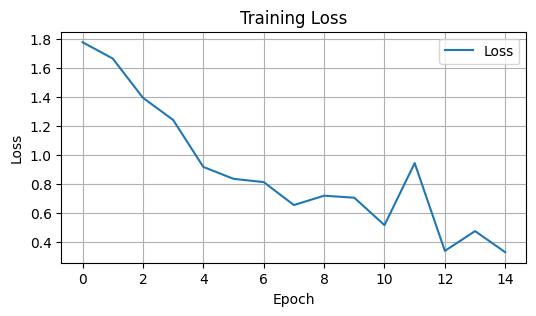

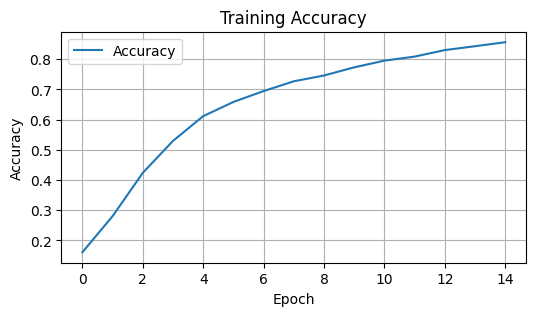

In [13]:
import matplotlib.pyplot as plt

# Loss
plt.figure(figsize=(6, 3))
plt.plot(loss_arr, label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy
plt.figure(figsize=(6, 3))
plt.plot(accuracy_arr, label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
model_path = './model/VGG.pth'

model = VGG(base_dim=64).to(device)

checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

with torch.no_grad():
    for image, label in testloader:
        x = image.to(device)
        y_ = label.to(device)
        output = model(x)
        
        _, predicted = torch.max(output, 1)
        accuracy = (predicted == y_).sum().item() / len(y_)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 81.25%
